In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

TUXML_CSV_FILENAME="./config_bdd.csv"
tuxdata = pd.read_csv(open(TUXML_CSV_FILENAME, "r"))

tri_state_values = ['y', 'n', 'm']

ftuniques = []
freq_ymn_features = []
non_tristate_options = []

for col in tuxdata:
    ft = tuxdata[col]    
    # eg always "y"
    if len(ft.unique()) == 1:
        ftuniques.append(col)
    # only tri-state values (y, n, m) (possible TODO: handle numerical/string options)    
    elif all(x in tri_state_values for x in ft.unique()):     #len(ft.unique()) == 3: 
        freq = ft.value_counts(normalize=True)
        freqy = 0
        freqn = 0
        freqm = 0
        if ('y' in freq.index):
            freqy = freq['y']
        if ('n' in freq.index):
            freqn = freq['n']
        if ('m' in freq.index):
            freqm = freq['m']
        freq_ymn_features.append((col, freqy, freqm, freqn))
        # categorical variable
        #if tuxdata[col].dtype == 'object':
        #    try:
        #        tuxdata[col] = tuxdata[col].astype('category')
        #    except:
        #        print('Column', ' ', col, ' cannot be converted to category.')
    else:
        non_tristate_options.append(col)
        

### TODO: we want to keep all quantitative values!
non_tristate_options.remove('vmlinux')


#### print options with unique values
# options with only one value eg always "y"
#i = 0
#for ft in ftuniques:
#    print(ft + " (" + str(i) + ")")
#    i = i + 1

print ("Number of options with only one value (eg always y): " + str(pd.DataFrame(ftuniques).shape))
# maybe we can drop options with only one unique value (no interest for machine learning)
tuxdata.drop(columns=ftuniques,inplace=True)

print ("Non tri-state value options (eg string or integer or hybrid values): " 
       + str(pd.DataFrame(non_tristate_options).shape) + " ") 
#      + str(pd.DataFrame(non_tristate_options)))

print ("Predictor variables: " + str(tuxdata.drop(columns=non_tristate_options).columns.size))
# frequency of y, m, and n values 
#plt.figure()
#pd.DataFrame(freq_ymn_features, columns=["feature", "freqy", "freqm", "freqn"]).plot(kind='hist', alpha=0.8) #plot()
#plt.show()
    



/usr/local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (11858,12378,12384) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Number of options with only one value (eg always y): (3171, 1)
Non tri-state value options (eg string or integer or hybrid values): (191, 1) 
Predictor variables: 9457


In [2]:
# playing a bit with the data 
tuxdata['vmlinux']
tuxdata.dtypes
# 'DEBUG_INFOO' in list(pd.DataFrame(non_tristate_options)[0]) # 
# tuxdata['DEBUG_INFO'].unique()
#tuxdata['OUTPUT_FORMAT'].dtypes
#tuxdata['DEFAULT_HOSTNAME'].unique()

tuxdata[:5]
#tuxdata[:5]['CONFIG_DEBUG_INFO']
#tuxdata['ARCH_HAS_SG_CHAIN'].unique()
#tuxdata['ARCH_HAS_SG_CHAIN'].astype('category')

,cid,date,time,vmlinux,GZIP-bzImage,GZIP-vmlinux,GZIP,BZIP2-bzImage,BZIP2-vmlinux,BZIP2,...,SG_SPLIT,SG_POOL,ARCH_HAS_SG_CHAIN,ARCH_HAS_PMEM_API,ARCH_HAS_UACCESS_FLUSHCACHE,ARCH_HAS_MMIO_FLUSH,STACKDEPOT,SBITMAP,PARMAN,PRIME_NUMBERS
0,70000,2018-06-28 11:12:54,178.783,26515720,7152080,9237632,7007790,11112912,13197904,6848173,...,y,n,y,y,y,y,y,n,y,y
1,70001,2018-06-28 11:12:56,353.739,143327264,21517264,23602640,21371013,23094224,25179048,18829150,...,n,y,y,y,y,y,y,y,n,n
2,70002,2018-06-28 11:13:38,175.054,39857248,6710736,8796880,6499098,10946000,13031592,6617781,...,y,n,y,y,y,y,y,n,y,y
3,70003,2018-06-28 11:13:55,449.300,124632912,19809744,21894608,19659717,22795728,24880040,18528942,...,n,y,y,y,y,y,y,y,n,y
4,70004,2018-06-28 11:14:05,306.612,-1,-1,-1,-1,-1,-1,-1,...,n,y,y,y,y,y,y,y,n,y


In [3]:
#from category_encoders import *
from sklearn.preprocessing import *

#X = [['y', 1], ['n', 3], ['m', 2]]
#enc.fit(X)
#enc.transform(tuxdata)

#enc = OrdinalEncoder().fit(tuxdata[:10])

# transform the dataset
#enc.transform(tuxdata[:10])

# 1. INSTANTIATE
# encode labels with value between 0 and n_classes-1.
le = LabelEncoder()


# 2/3. FIT AND TRANSFORM
# use df.apply() to apply le.fit_transform to all columns
#print(non_tristate_options)

# we save quantitative values we want (here vmlinux, TODO: generalize)
# the key idea is that the labelling encoder should not be applied to this kind of values (only to predictor variables!)
vml = tuxdata['vmlinux'] 


# we remove non tri state options, but TODO there are perhaps some interesting options (numerical or string) here
tuxdata = tuxdata.drop(columns=non_tristate_options).drop(columns=['vmlinux']).apply(le.fit_transform)
    
tuxdata['vmlinux'] = vml 
# example: DEBUG_INFO is either y or n
tuxdata['DEBUG_INFO'].unique()

array([0, 1])

In [8]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor, GradientBoostingRegressor



TESTING_SIZE=0.1 

# drop(columns=["date", "time", "vmlinux", "cid"])
# tuxdata.drop(columns=non_tristate_options)

X_train, X_test, y_train, y_test = train_test_split(tuxdata.drop(columns=['vmlinux']), tuxdata['vmlinux'], test_size=TESTING_SIZE, random_state=0)  
clf = GradientBoostingRegressor(n_estimators=100) # RandomForestRegressor(n_estimators=100) # 
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]    

TOP_FT_IMPORTANCE=20
print("Feature ranking: " + "top (" + str(TOP_FT_IMPORTANCE) + ")")
for f in range(TOP_FT_IMPORTANCE): # len(indices)
    print("%d. feature %s %d (%f)" % (f + 1, tuxdata.columns[indices[f]], indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
#plt.figure()
#plt.title("Feature importances for size of vmlinux")
#plt.bar(range(tuxdata.shape[1]), importances[indices], color="r", align="center")
#plt.xticks(range(tuxdata.shape[1]), indices)
#plt.xlim([-1, tuxdata.shape[1]])
#plt.show()
mae = mean_absolute_error (y_test, y_pred)
mse = mean_squared_error (y_test, y_pred) 
r2 = r2_score (y_test, y_pred) 
print("Prediction score (MAE): %.2f" % (mae))
print("Prediction score (MSE): %.2f" % (mse))
print("Prediction score (R2): %.2f" % (r2))


Feature ranking: top (20)
1. feature DEBUG_INFO 8797 (0.107065)
2. feature DEBUG_INFO_REDUCED 8798 (0.052007)
3. feature DEBUG_INFO_SPLIT 8799 (0.030693)
4. feature AIC7XXX_BUILD_FIRMWARE 2129 (0.029624)
5. feature UBSAN_SANITIZE_ALL 9035 (0.029507)
6. feature AIC79XX_BUILD_FIRMWARE 2133 (0.028219)
7. feature GCOV_PROFILE_ALL 307 (0.018596)
8. feature GDB_SCRIPTS 8801 (0.017715)
9. feature X86_NEED_RELOCS 597 (0.012740)
10. feature RANDOMIZE_BASE 596 (0.012200)
11. feature KASAN_OUTLINE 8859 (0.011891)
12. feature SND_SOC_CS35L33 6221 (0.011478)
13. feature COMEDI_USBDUXSIGMA 7431 (0.010600)
14. feature PACKET_DIAG 825 (0.009982)
15. feature HSU_DMA_PCI 7223 (0.009667)
16. feature KASAN 8858 (0.009608)
17. feature SQUASHFS_EMBEDDED 8639 (0.008935)
18. feature DEBUG_INFO_DWARF4 8800 (0.008367)
19. feature COMEDI_DT2817 7340 (0.008044)
20. feature DM9102 2582 (0.007677)
Prediction score (MAE): 31364875.78
Prediction score (MSE): 6010934635832570.00
Prediction score (R2): 0.49


<Figure size 432x288 with 0 Axes>

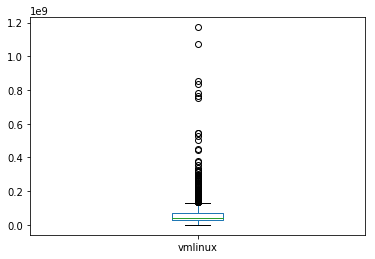

In [5]:
plt.figure()
pd.DataFrame(tuxdata['vmlinux']).plot.box()
plt.show()

In [6]:
ft_vals = ['y', 'n'] 
tri_state_values = ['y', 'n', 'm']
all(x in tri_state_values for x in ft_vals)

True